# Univariate Time-series analysis and forecasting of Crude Oil prices(IB)

The data consists of International Prices of Crude oil(Time-series data) taken from PPAC(Petroleum Planning and Ananlysis Cell)
https://ppac.gov.in/prices/international-prices-of-crude-oil .
The Indian basket of Crude Oil represents a derived basket comprising of Sour grade (Oman & Dubai average) and Sweet grade (Brent Dated) of Crude oil processed in Indian refineries in the ratio of 75.62 : 24.38. 

This Project involves EDA,multiplicative decomposition of the time-series data, followed by evaluating ARIMA,SARIMA performance (using recursive strategy for multi-step forecast) and predicting 10-points forecast.

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import log
from math import sqrt
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import dates as dt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import model_selection
from arch import arch_model
import warnings

## Data preprocessing

In [2]:
df=pd.read_csv("1711946786_crude-h.csv")
df.drop(columns=["Unnamed: 15","Average","Ratio *"],inplace=True) #dropping unnecessary columns
df=df.dropna()#dropping NaN values
df.set_index(["Year"],inplace=True)

In [3]:
df

,April,May,June,July,August,September,October,November,December,January,February,March
Year,,,,,,,,,,,,
2000-01,22.51,26.60,28.49,27.26,28.33,31.34,30.50,30.93,23.25,24.02,25.92,23.82
2001-02,24.82,26.95,26.63,23.99,25.01,24.79,20.05,18.24,18.24,18.92,19.53,23.31
2002-03,25.03,24.99,24.05,25.18,25.86,27.50,26.90,23.68,27.11,29.59,31.31,28.83
2003-04,24.21,24.99,26.43,27.46,28.66,26.27,28.45,28.23,28.97,30.00,29.65,32.21
2004-05,32.37,36.08,34.16,36.35,40.52,39.15,43.38,38.90,36.82,40.96,42.67,49.27
2005-06,49.43,47.00,52.72,55.01,60.05,59.74,56.28,53.14,55.05,60.54,58.95,60.01
2006-07,67.06,67.22,66.90,71.29,70.78,60.93,57.27,57.79,60.34,52.53,56.53,60.26
2007-08,65.48,65.70,68.10,72.58,68.98,74.78,79.33,89.11,87.92,89.52,92.37,99.76
2008-09,105.72,120.91,129.72,132.47,113.05,96.81,69.12,50.91,40.61,43.99,43.22,46.02


The given data is not in Time-series format yet, and thus needs to be converted.

In [ ]:
df1=df.iloc[:,:9]
df1= df1.stack().reset_index()
df1.columns=['Year','Month','Price']
df1['Date']=pd.to_datetime(df1['Year'].str.slice(0,4)+'-'+df1['Month'],format='%Y-%B')
df1.drop(columns=['Year','Month'],inplace=True)
df1.head()

In [ ]:
df2=df.iloc[:,9:]
df2= df2.stack().reset_index()
df2.columns=['Year','Month','Price']
df2['Date']=pd.to_datetime('20'+df2['Year'].str.slice(-2)+'-'+df2['Month'],format='%Y-%B')
df2.drop(columns=['Year','Month'],inplace=True)
df2.head()

In [ ]:
df_new=pd.concat([df1,df2])
df_new.tail(5)

In [7]:
df_new=df_new.sort_values(by="Date")
df_new.set_index(['Date'],inplace=True)
df_new=df_new.asfreq(pd.infer_freq(df_new.index))

Text(0.5, 1.0, 'International Price of Crude Oil(IB)')

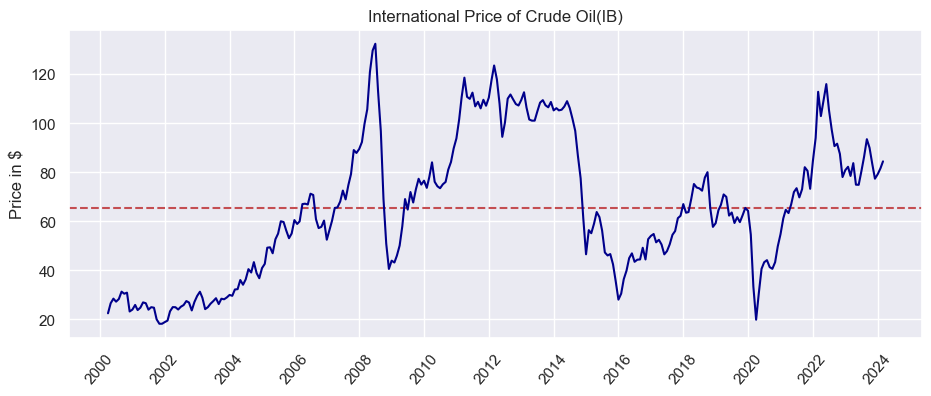

In [8]:
sns.set(rc={'figure.figsize':(11, 4)})
fig,ax=plt.subplots()
ax.xaxis.set_major_locator(dt.AutoDateLocator(maxticks=26))
ax.xaxis.set_major_formatter(dt.DateFormatter('%Y'))
plt.axhline(df_new['Price'].mean(),color='r',linestyle='--',alpha=1)
plt.xticks(rotation = 50)
plt.ylabel("Price in $")
ax.plot(df_new['Price'],color="DarkBlue")
plt.title("International Price of Crude Oil(IB)")

It is evident from the above plot that the trend is not constant,also there are instances of increasing and decreasing volatility i.e change in variance over time and thus the given data is non-stationary

In [48]:
df_new.describe()

,Price,first_difference,seasonal_difference
count,288.000000,288.000000,288.000000
mean,65.321667,0.215208,0.016111
std,28.508975,5.772462,8.020911
min,18.240000,-27.690000,-32.240000
25%,43.310000,-2.375000,-3.932500
50%,63.585000,1.010000,0.000000
75%,84.535000,3.715000,3.515000
max,132.470000,18.800000,33.050000


In [ ]:
print(df_new[['Price']].idxmin())
print(df_new[['Price']].idxmax())

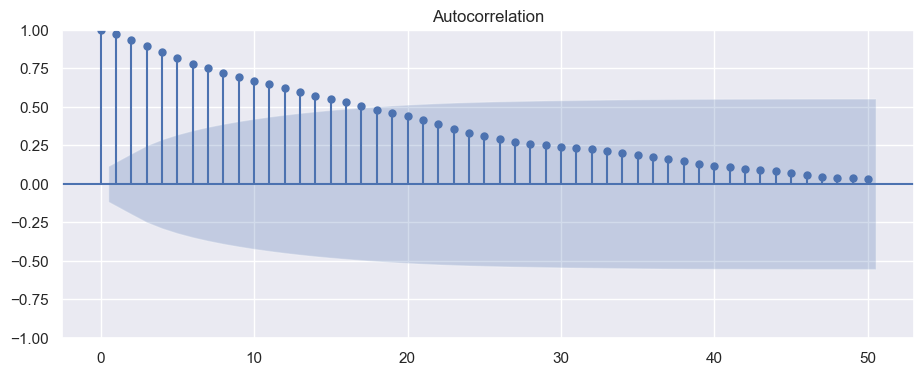

In [9]:
plot_acf(df_new["Price"],lags=50)
plt.show()

Also plotting the ACF, we can see that it drops rather quite slowly indicating that the series is non stationary.

## ADF test for stationarity

ADF test tests the null hypothesis that a unit root is present in the time series.
* If the p-value<0.05,reject null and conclude that the time series is stationary.
* If p-value>0.05,failed to reject null and time series is non stationary.In this case ADF statistic which should be greater than the critical values.

In [10]:
adftest=adfuller(df_new["Price"],autolag='AIC')
print(f'ADF Statistic: {adftest[0]}')
print(f'p_value: {adftest[1]}')
print(f'n_lags: {adftest[2]}')
for key,value in adftest[4].items():
    print(f'{key},    {value}')

ADF Statistic: -2.663523042783802
p_value: 0.08056584666820382
n_lags: 1
1%,    -3.4534232986669546
5%,    -2.8716994185534745
10%,    -2.5721833625116144


## Mathematical Decomposition

In [11]:
#p=0.08056584666820382>0.05, fail to reject null, series is non stationary
if adftest[1]>0.05:
    decompose=seasonal_decompose(df_new,model='multiplicative',period=12, extrapolate_trend= 12)
else:
    decompose=seasonal_decompose(df_new,model='additive',period=12,extrapolate_trend=12)

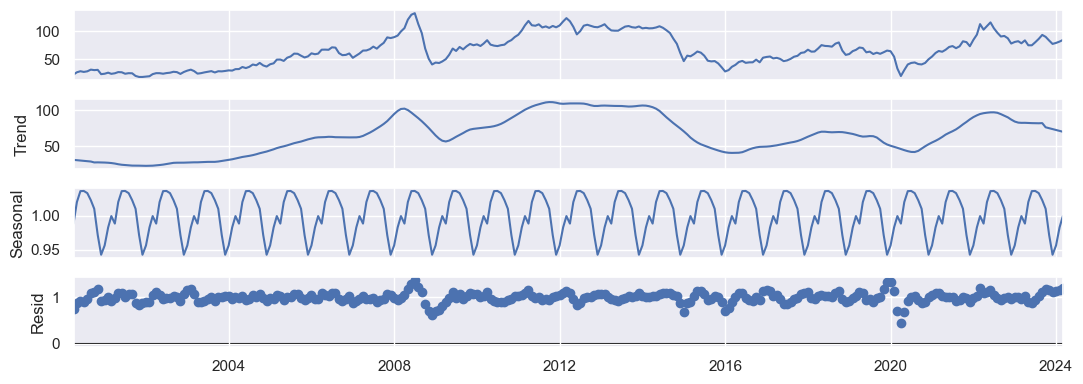

In [12]:
decompose.plot()
plt.show()

## Interpretation of Detrended and Seasonally adjusted plots
Detrended values is the data with trend removed and are obtained by dividing the observed values with the trend values(for multiplicative model).If the plot of detrend data looks different from the original data, it can be concluded that the trend component exists.

Similar procedure can be followed for seasonally adjusted values.

In [13]:
df2=pd.DataFrame({'trend':decompose.trend,"seasonal":decompose.seasonal,'residual':decompose.resid})
df_ds=(df_new['Price']/df2['seasonal'])#seasonally adjusted values
df_dt=(df_new['Price']/df2['trend'])*100 #detrended values
df_dsdt=df_dt/df2['seasonal']#detrended and deseasonalised values that represents residuals

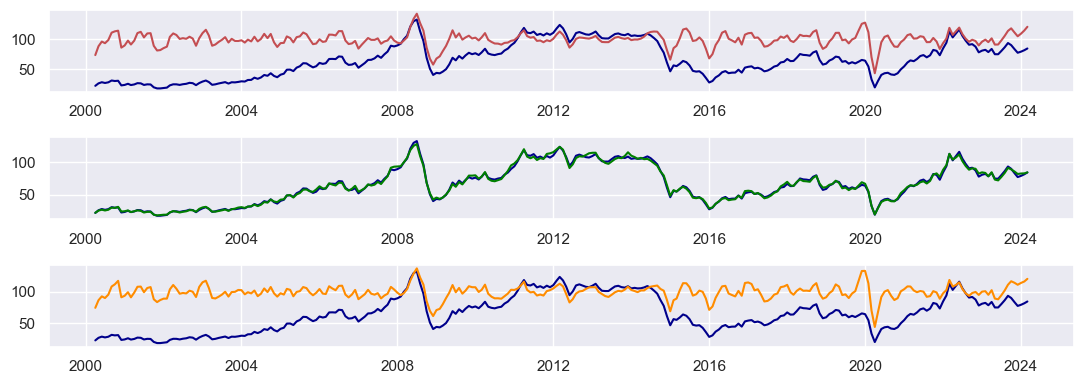

In [14]:
fig,ax=plt.subplots(3)
ax[0].plot(df_new['Price'],color='darkblue',label='Original data')
ax[0].plot(df_dt,color='r',label='Detrended data')
#Trend component exists

ax[1].plot(df_new['Price'],color='darkblue',label='Original data')
ax[1].plot(df_ds,color='green',label='Deseasonalised data')
#seasonality is not quite significant

ax[2].plot(df_new['Price'],color='darkblue',label='Original data')
ax[2].plot(df_dsdt,color='darkorange',label='Detrended and deseasonalised data')
plt.tight_layout()

## Calculating trend using Moving average

seaonal_decompose() uses moving average method to calculate decompose time-series data.Let's now understand the intuition behind this function.
Detrend the data using rolling window method,which splits the data into time-windows and the data in each window is aggregated with a function such as mean(),sum() etc. Given we have monthly data,compute 12-months rolling mean(use the center=True argument to label each window at its midpoint) 

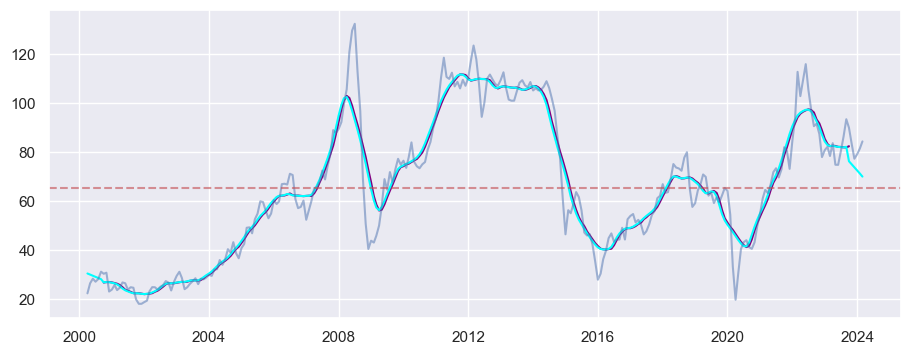

In [15]:
df2["MA_trend"]=df_new["Price"].rolling(12,center=True).mean()
plt.plot(df2["MA_trend"],color="purple")
plt.plot(df2["trend"],color="cyan")
plt.plot(df_new["Price"],color="b",alpha=0.5)
plt.axhline(df_new['Price'].mean(),color='r',linestyle='--',alpha=0.6)
plt.show()

## EDA(for calculating p,q,d,P,Q,D,m)

Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

In [16]:
df_new['first_difference']=df_new['Price'].diff(1)
df_new.head()
df_new.fillna(0,inplace=True)

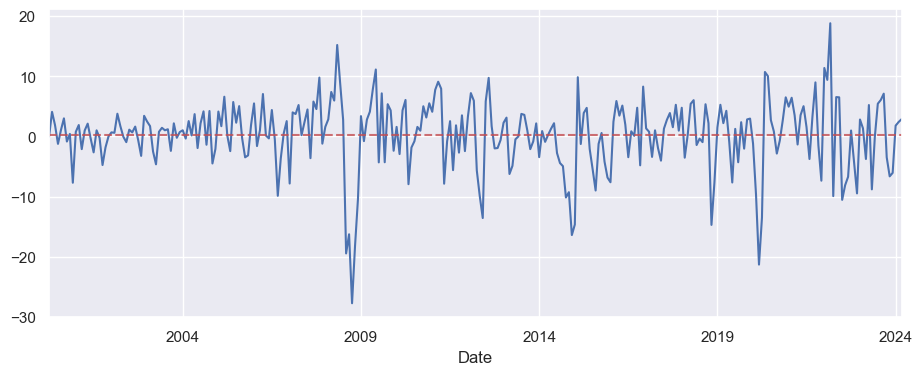

In [17]:
df_new['first_difference'].plot()
plt.axhline(df_new['first_difference'].mean(),color='r',linestyle='--',alpha=0.8)
plt.show()

In [18]:
#ADF test to check for stationarity of first differences
adftest=adfuller(df_new["first_difference"],autolag='AIC')
print(f'ADF Statistic: {adftest[0]}')
print(f'p_value: {adftest[1]}')
print(f'n_lags: {adftest[2]}')
for key,value in adftest[4].items():
    print(f'{key},    {value}')

ADF Statistic: -11.502556227669041
p_value: 4.455130760277525e-21
n_lags: 0
1%,    -3.453342167806272
5%,    -2.871663828287282
10%,    -2.572164381381345


A seasonal difference is the difference between an observation and the previous observation from the same season.It is used to remove the seasonal variations from the data. 

In [19]:
#differencing for seasonal adjustments
df_new["seasonal_difference"]=df_new["first_difference"].diff(12)
df_new.fillna(0,inplace=True)

In [20]:
adftest=adfuller(df_new["seasonal_difference"],autolag='AIC')
print(f'ADF Statistic: {adftest[0]}')
print(f'p_value: {adftest[1]}')
print(f'n_lags: {adftest[2]}')
for key,value in adftest[4].items():
    print(f'{key},    {value}')

ADF Statistic: -6.86069036084967
p_value: 1.6054010244176015e-09
n_lags: 12
1%,    -3.454355055831705
5%,    -2.8721080938842976
10%,    -2.572401325619835


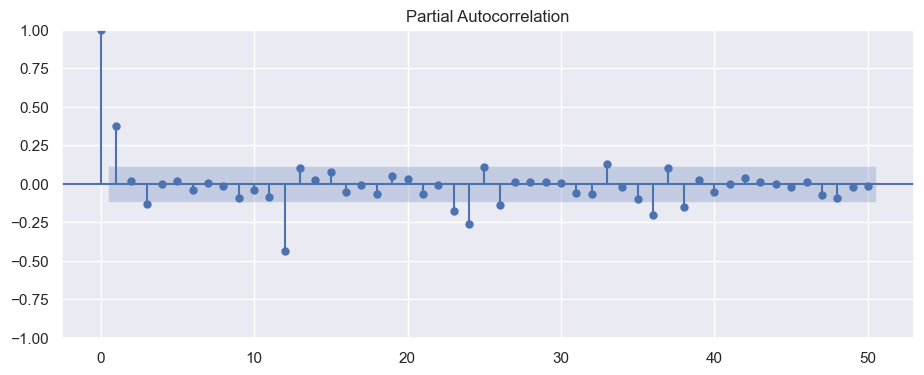

In [21]:
plot_pacf(df_new['seasonal_difference'], lags=50)
plt.show()

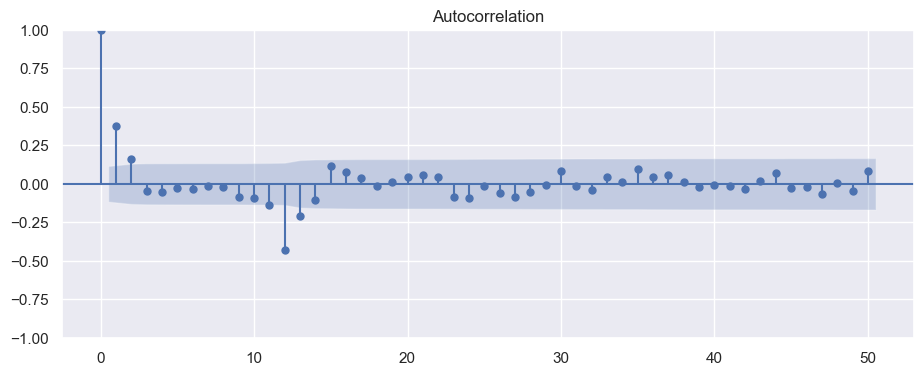

In [22]:
plot_acf(df_new['seasonal_difference'], lags=50)
plt.show()

## Evaluating ARIMA and SARIMA performance
Multi-step forecast gives a straight line. It’s more challenging because it relies on extrapolating beyond the immediate next point.

Time-series forecasting is usually preferred at a one-step forecast and multi-step is often challenging.However various strategies have been developed to deal with this the prominent ones being- recursive,direct,DirRec(hybrid of direct and recursive),Multi-Input Multi-Output (MIMO) and DIRMO( a hybrid of MIMO and DirRec).


In this project, The recursive strategy is used which involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.

In [23]:
#train-test split
X=df_new["Price"]
train_size=int((0.7)*len(X))
train,test=X[:train_size],X[train_size:]

In [ ]:
#Using ARIMA to forecast
model_arima=pm.auto_arima(train,start_p=1,max_q=3,max_p=3,d=1,stepwise=True,Trace=True,seasonal=False)
print(model_arima.summary())
pred_arima,conf_int=model_arima.predict(n_periods=test.shape[0],return_conf_int=True)
error_autoarima= np.sqrt(mean_squared_error(test, pred_arima))

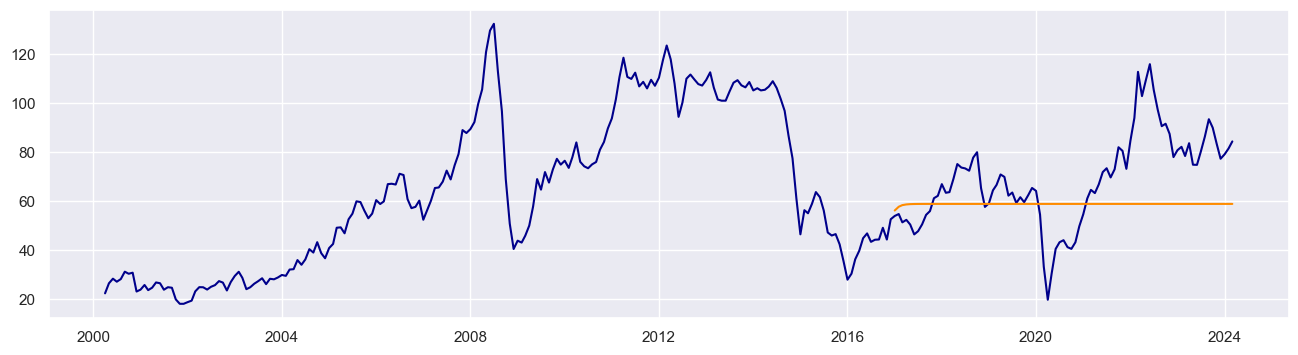

In [25]:
fig,ax=plt.subplots(figsize=(16,4))
ax.plot(df_new["Price"].index,df_new["Price"],label="Original_values",color='DarkBlue')
ax.plot(pred_arima,color='DarkOrange',label="Forecast")
plt.show()

In [26]:
#Using Rolling method to forecast using ARIMA
history=[x for x in train]
roll_pred=[]
roll_conf_int=[]
for i in range(len(test)):
    rolling_arima=ARIMA(history,order=(1,1,0)).fit()
    y=rolling_arima.forecast()[0]
    roll_pred.append(y)
    history.append(test[i])
error_rollarima=sqrt(mean_squared_error(roll_pred,test))

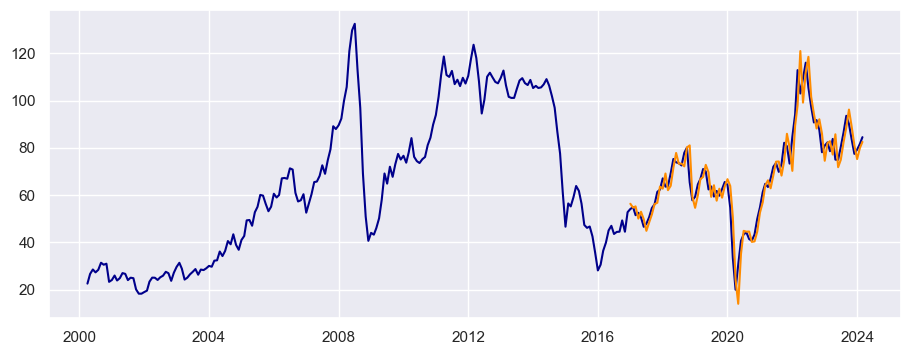

In [27]:
plt.plot(df_new["Price"].index,df_new["Price"],label="Actual values",color="DarkBlue")
plt.plot(test.index,roll_pred,label="Rolling Predictions",color="DarkOrange")
plt.show()

In [ ]:
residuals=test-roll_pred


In [29]:
#Using SARIMA to forecast
model_sarima=pm.auto_arima(train,start_p=1,q=1,max_p=3,d=1,stepwise=True,Trace=True,seasonal=True,D=1,m=12,start_P=0,start_Q=0,max_P=15,max_Q=15)
print(model_sarima.summary())
predictions,conf_int=model_sarima.predict(n_periods=test.shape[0],return_conf_int=True)
error_sarima=np.sqrt(mean_squared_error(test, predictions))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  201
Model:             SARIMAX(1, 1, 0)x(7, 1, 0, 12)   Log Likelihood                -586.584
Date:                            Tue, 21 May 2024   AIC                           1191.168
Time:                                    14:35:47   BIC                           1220.296
Sample:                                04-01-2000   HQIC                          1202.969
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4267      0.047      9.045      0.000       0.334       0.519
ar.S.L12      -0.7900      0.062   

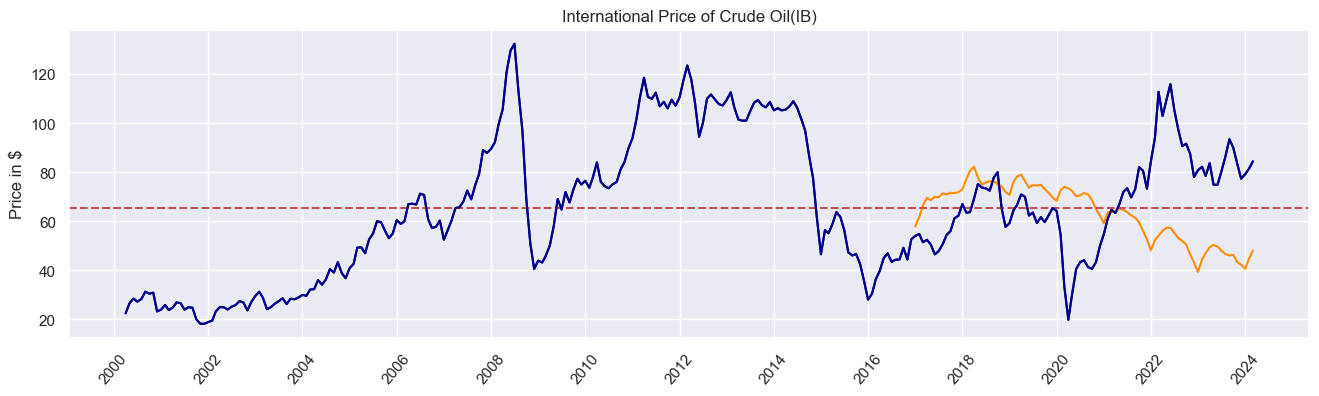

In [30]:
fig,ax=plt.subplots(figsize=(16,4))
ax.plot(df_new.index,df_new["Price"],label="Original_values",color='darkblue')
ax.plot(test.index,predictions,label="Predicted_values",color='darkorange')
ax.xaxis.set_major_locator(dt.AutoDateLocator(maxticks=26))
ax.xaxis.set_major_formatter(dt.DateFormatter('%Y'))
plt.axhline(df_new['Price'].mean(),color='r',linestyle='--',alpha=1)
plt.xticks(rotation = 50)
plt.ylabel("Price in $")
ax.plot(df_new['Price'],color="DarkBlue")
plt.title("International Price of Crude Oil(IB)")
plt.show()

Clearly predicting n steps at a time doesn't give nice results and thus we approach the recursive strategy

In [ ]:
cv_roll=model_selection.RollingForecastCV(h=1,step=1,initial=201)
est_rollsarima=pm.ARIMA(order=(1,1,0),seasonal_order=(7,1,0,12),suppress_warnings=True)
cv_pred=model_selection.cross_val_predict(est_rollsarima,df_new["Price"],cv=cv_roll,verbose=2,averaging="median")

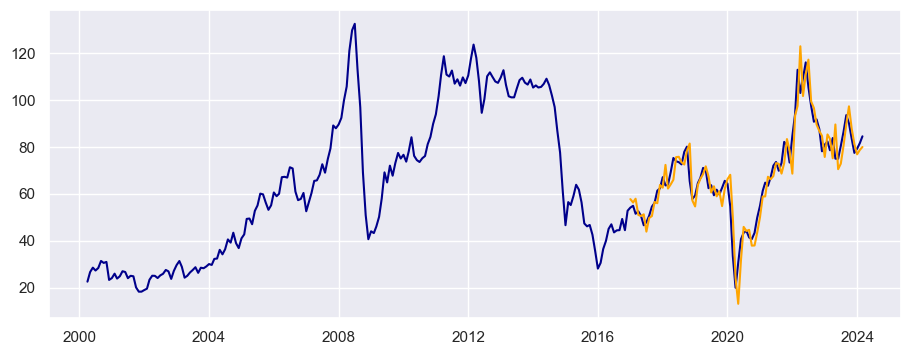

In [32]:
x_axis1=df_new.index
n_test1=len(cv_pred)
plt.plot(x_axis1,df_new["Price"],c='Darkblue')
plt.plot(x_axis1[-n_test1:],cv_pred,c='orange')
plt.show()

In [33]:
error_rollsarima=sqrt(mean_squared_error(cv_pred,test))
print(f"error-\nrollingARIMA={error_rollarima:.4f}\nAutoARIMA={error_autoarima: .4f}\nrollSARIMA={error_rollsarima: .4f}\nAutoSARIMA={error_sarima: .4f}")

error-
rollingARIMA=6.1377
AutoARIMA= 20.7986
rollSARIMA= 6.6290
AutoSARIMA= 27.2320


Auto.arima doesn't always find the best parameters for the model and further hyperparameter tuning could be performed to enhance the performance by finding the parameters(i.e the order (p,q,d) and seasonal order(P,Q,D,m)) using gridsearch(computationally expensive and relatively slow),bayesian optimization,using AIC or BIC or even testing manually.

## Forecasting using ARIMA and SARIMA

In [54]:
#Forecasting future values by training on the entire dataset
train1=[x for x in df_new["Price"]]
forecasts=[]
for i in range(10):
    rolling_arima1=ARIMA(train1,order=(1,1,0)).fit()
    y1=rolling_arima1.forecast()[0]
    forecasts.append(y1)
    train1.append(y1)
print(forecasts)

[85.53974609431712, 85.9237113032325, 86.06415578424053, 86.1155273310065, 86.13431815103002, 86.1411915874078, 86.14370582988859, 86.14462552828253, 86.14496195361365, 86.14508501927996]


In [56]:
forecast_dates=["2024-04-01","2024-05-01","2024-06-01","2024-07-01","2024-08-01","2024-09-01","2024-10-01","2024-11-01","2024-12-01","2025-01-01"]
datetime_list = [datetime.strptime(date, "%Y-%m-%d") for date in forecast_dates]

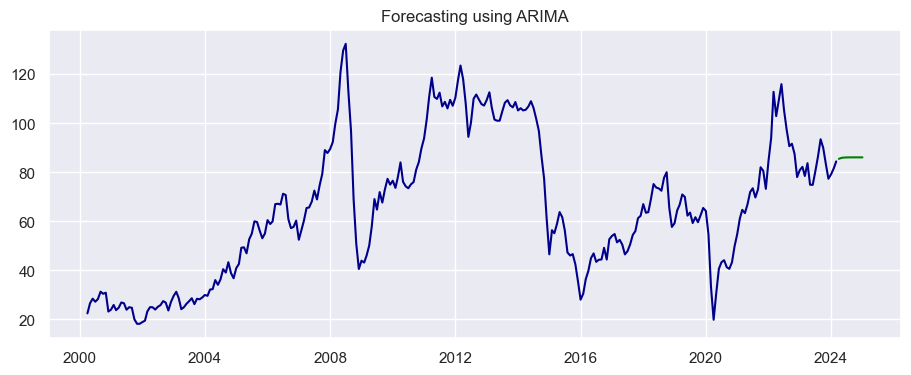

In [42]:
plt.title("Forecasting using ARIMA")
plt.plot(x_axis1,df_new["Price"],c='Darkblue')
plt.plot(datetime_list,forecasts,c='green')
plt.show()

In [38]:
#Forecasting future values by training on the entire dataset
train2=[x for x in df_new["Price"]]
forecasts_sa=[]
for i in range(10):
    rolling_sarima1=SARIMAX(train1,order=(1,1,0),seasonal_order=(7,1,0,12)).fit()
    y2=rolling_sarima1.forecast()[0]
    forecasts_sa.append(y2)
    train1.append(y2)
print(forecasts_sa)

[87.12738689951532, 87.54499207472477, 87.56819464164657, 89.61684415385258, 89.39428371481836, 89.58423715821453, 87.93137028786903, 89.82842921783491, 91.24511406445711, 89.53803207526924]


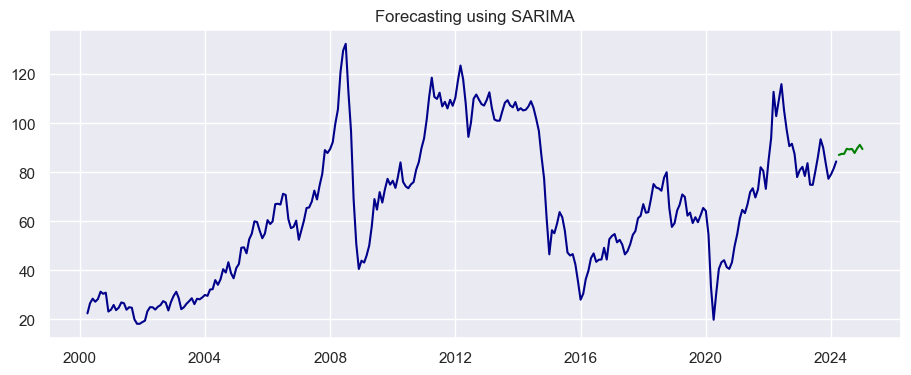

In [43]:
plt.title("Forecasting using SARIMA")
plt.plot(x_axis1,df_new["Price"],c='Darkblue')
plt.plot(datetime_list,forecasts_sa,c='green')
plt.show()

## Findings and Conclusion

Plotting detrended,deseasonalised values,it can be interpretated that there isn't significant seasonality,but presence of strong trend and variance is reflected.
Also the RMSE for ARIMA is less than SARIMA by 0.49(could be because of overfitting of SARIMA model, or lack of seasonality)
However even with a higher sampling error,SARIMA may be more accurate for long-term forecasts as it also accounts for the seasonal component.

This project performs 10 points forecasts using the recursive strategy from April-2024 to January-2025.Further improvements could be done by using ensemble models of ARIMA-GARCH,deep learning models(SARIMA-ANN,LSTM etc) for better predictions.